**Importando Bibliotecas**

In [29]:
import pandas as pd;
import numpy as np;
import matplotlib.pyplot as plt;
import warnings;
from statsmodels.tsa.api import (kpss, adfuller, seasonal_decompose, STL);
from statsmodels.tools.eval_measures import rmse, rmspe;
from sklearn.metrics import mean_absolute_percentage_error as mape;
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf;
from itertools import product;
from pathlib import Path;

warnings.filterwarnings('ignore');
plt.rcParams['figure.figsize'] = [18,8]

**Importando os datasets**

In [2]:
arquivo_life = Path('life_expectancy_birth.csv');
arquivo_milk = Path('milk_production.csv');

life = pd.read_csv(arquivo_life, index_col='year', parse_dates=True, skipfooter=1);
milk = pd.read_csv(arquivo_milk, index_col='month', parse_dates=True);

In [3]:
life.head()

,value
year,
1960-01-01,69.123902
1961-01-01,69.760244
1962-01-01,69.149756
1963-01-01,69.248049
1964-01-01,70.311707


In [4]:
milk.head()

,production
month,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


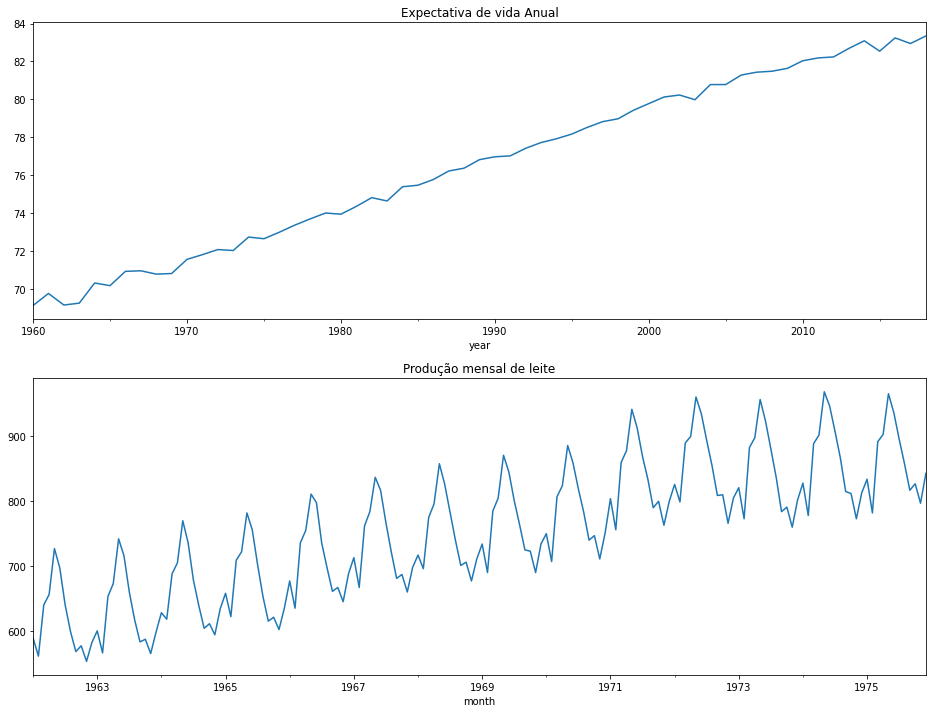

In [5]:
fig, ax = plt.subplots(2, 1, figsize = (16, 12));
life.plot(title='Expectativa de vida Anual', legend=False, ax=ax[0]);
milk.plot(title='Produção mensal de leite', legend=False, ax=ax[1]);

In [6]:
def split_data(data, test_split):
    l = len(data);
    t_idx = round(l * (1 - test_split));
    train, test = data [ : t_idx ], data[t_idx: ];
    print(f'treino: {len(train)}, Teste: {len(test)}');
    return train, test;


**Chamada para a função *split_data* para dividir os dois DATAFRAMES em test e train.**

In [7]:
test_split = 0.15;
milk_train, milk_test = split_data ( milk, test_split);
life_train, life_test = split_data ( life, test_split);


treino: 143, Teste: 25
treino: 50, Teste: 9


In [8]:
def check_stationarity(df):
    results = adfuller(df)[1:3];
    s = 'Não Estacionaria';
    if results[0] < 0.05:
        s = 'Estacionaria';
    print(f"'{s}\t p-valor: {results[0]}\t lags: {results[1]}'");
    return (s, results[0]);

In [35]:
def get_best_model(score, c='AIC'):
    initial_score = score[0][c];
    best_model = 0;
    for k, v in score.items():
        if v[c] < initial_score:
            initial_score = v[c];
            best_model = k;
    print(f'Melhor modelo é: {best_model} com menor {c} score: {initial_score}');
    return score[best_model]['model']

In [57]:
def plot_forecast ( model , start, train, test):
    forecast = pd.DataFrame(model.forecast(test.shape[0]), index=test.index);
    ax = train.loc[start: ].plot(style = '--');
    test.plot(ax = ax);
    forecast.plot(ax=ax, style='-.')
    ax.legend(['orig_train', 'orig_test', 'forecast']);
    plt.show();

In [11]:
def combinator(items):
    combo = [i for i in product(*items)];
    return combo;

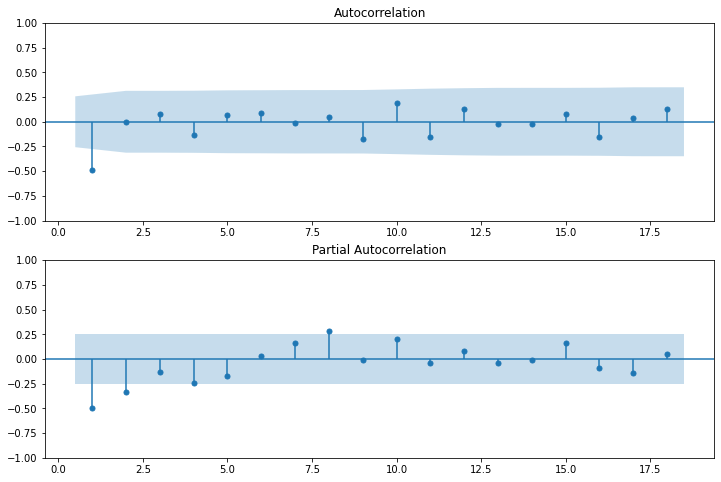

In [12]:
life_diff = life.diff().dropna();
fig, ax = plt.subplots(2, 1, figsize=(12,8));
plot_acf(life_diff, zero=False, ax=ax[0]);
plot_pacf(life_diff, zero=False, ax=ax[1]);
plt.show()

In [13]:
milk_diff_12 = milk.diff(12).dropna();

In [14]:
milk_diff_12

,production
month,
1963-01-01,11.0
1963-02-01,5.0
1963-03-01,13.0
1963-04-01,17.0
1963-05-01,15.0
...,...
1975-08-01,-9.0
1975-09-01,2.0
1975-10-01,15.0


In [15]:
check_stationarity(milk_diff_12);

'Não Estacionaria	 p-valor: 0.16079880527711227	 lags: 12'


In [16]:
milk_diff_12_1 = milk.diff(12).diff(1).dropna();
check_stationarity(milk_diff_12_1);

'Estacionaria	 p-valor: 1.86542343187882e-05	 lags: 11'


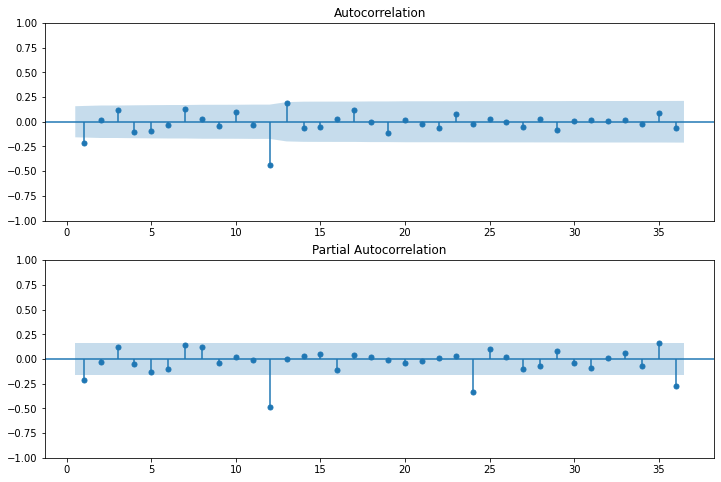

In [17]:
fig, ax = plt.subplots(2, 1, figsize=(12,8));
plot_acf(milk_diff_12_1, zero=False, ax=ax[0], lags=36);
plot_pacf(milk_diff_12_1, zero=False, ax=ax[1], lags=36);
plt.show()

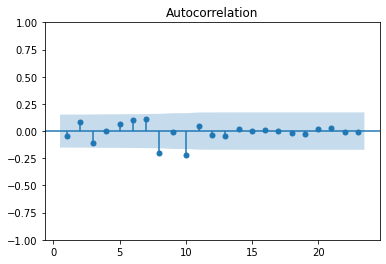

In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX;
model = SARIMAX(milk, order=(0,1,1), seasonal_order=(0,1,1, 12)).fit(disp=False);
plot_acf(model.resid[1:], zero=False);
plt.show()

In [20]:
from statsmodels.tsa.api import ExponentialSmoothing;

In [21]:
trend = ['add', 'mul'];
damped = [True, False];
life_ex_comb = combinator([trend, damped])
life_ex_comb

[('add', True), ('add', False), ('mul', True), ('mul', False)]

In [23]:
train = life_train.values.ravel();
y = life_test.values.ravel();
score = {};
for i, (t, dp) in enumerate(life_ex_comb):
    exp = ExponentialSmoothing(train, 
                               trend=t, 
                               damped_trend = dp,
                               seasonal = None,
                               )
    model = exp.fit(use_brute = True, optimized=True);
    y_hat = model.forecast(len(y));
    score[i] = {
        'trend': t,
        'damped': dp,
        'AIC' : model.aic,
        'BIC' : model.bic,
        'AICc' : model.aicc,
        'RMSPE' :rmspe(y, y_hat),
        'RMSE' : rmse(y, y_hat),
        'MAPE' : mape(y, y_hat),
        'model' : model
    }
    

In [24]:
life_best_model = get_best_model(score, 'AIC');

Melhor modelo é: 1 com menor AIC score: -137.0306018141099


In [25]:
life_best_model.summary()

Dep. Variable:,endog,No. Observations:,50
Model:,ExponentialSmoothing,SSE,2.749
Optimized:,True,AIC,-137.031
Trend:,Additive,BIC,-129.383
Seasonal:,None,AICC,-135.077
Seasonal Periods:,None,Date:,"Fri, 03 Feb 2023"
Box-Cox:,False,Time:,15:12:39
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.1621949,alpha,True
smoothing_trend,0.1621949,beta,True


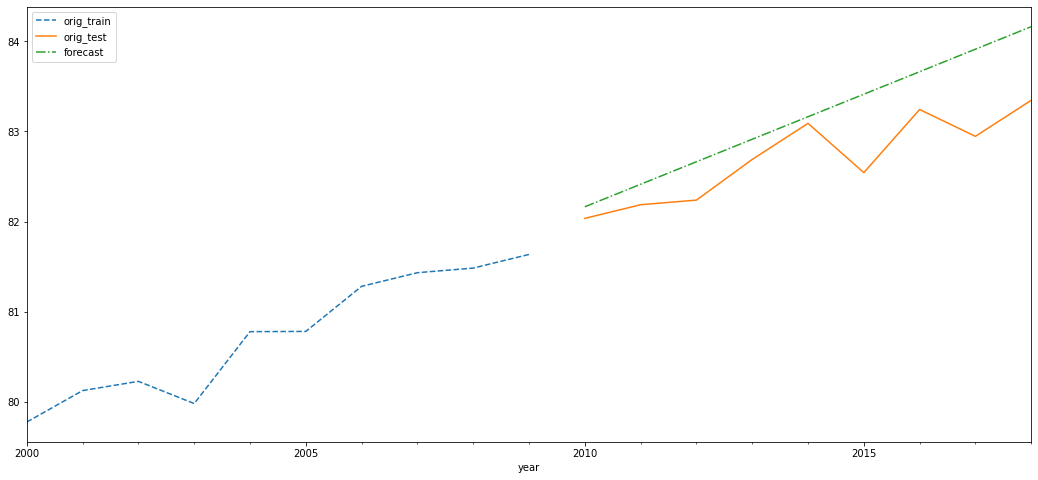

In [58]:
plot_forecast(life_best_model, '2000', life_train, life_test);

In [43]:
trend, damped = ['add', 'mul'], [True, False];
seasonal, periods = ['add', 'mul'], [4, 6, 12];
milk_exp_comb = combinator([trend, damped, seasonal,  periods])

In [51]:
train = milk_train.values.ravel();
y = milk_test.values.ravel();
milk_model_scores = {};
for i, (t, dp, s, sp) in enumerate(milk_exp_comb):
    exp = ExponentialSmoothing(train, 
                               trend = t,
                               damped_trend = dp,
                               seasonal = s,
                               seasonal_periods=sp
                               )
    model = exp.fit(use_brute = True, optimized=True);
    y_hat = model.forecast(len(y));
    milk_model_scores[i] = {
        'trend': t,
        'damped': dp,
        'AIC' : model.aic,
        'BIC' : model.bic,
        'AICc' : model.aicc,
        'RMSPE' :rmspe(y, y_hat),
        'RMSE' : rmse(y, y_hat),
        'MAPE' : mape(y, y_hat),
        'model' : model
    }

In [52]:
milk_model = get_best_model(milk_model_scores);

Melhor modelo é: 8 com menor AIC score: 593.7138794919351


In [55]:
milk_model.summary()

Dep. Variable:,endog,No. Observations:,143
Model:,ExponentialSmoothing,SSE,7265.655
Optimized:,True,AIC,593.714
Trend:,Additive,BIC,641.119
Seasonal:,Additive,AICC,599.230
Seasonal Periods:,12,Date:,"Fri, 03 Feb 2023"
Box-Cox:,False,Time:,15:53:24
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.6859083,alpha,True
smoothing_trend,0.000000,beta,True


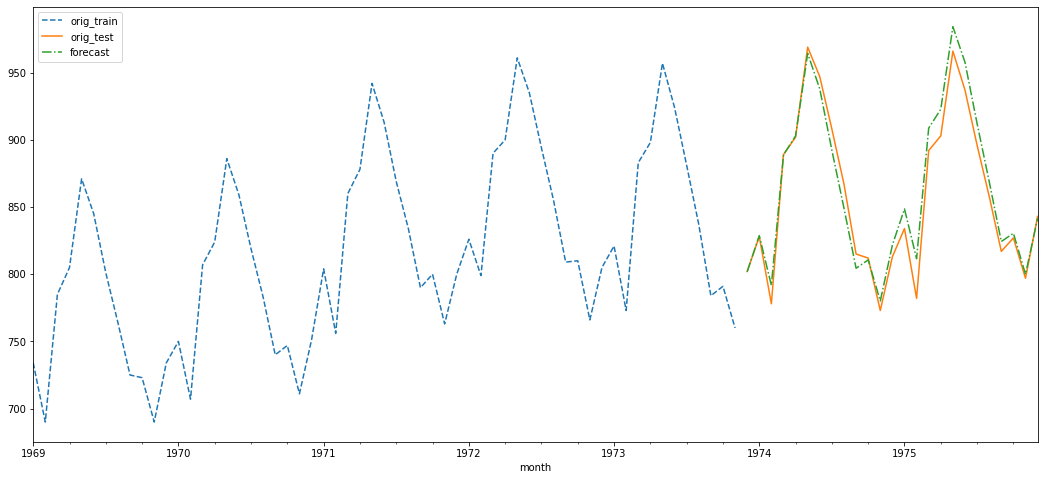

In [59]:
plot_forecast(milk_model, '1969',milk_train, milk_test)

In [60]:
from darts.models import ExponentialSmoothing;
from darts import TimeSeries;

In [61]:
model = ExponentialSmoothing(seasonal_periods=12);
ts = TimeSeries.from_dataframe(milk.reset_index(),
                               time_col='month',
                               value_cols='production', 
                               freq='MS')

treino: 143, Teste: 25


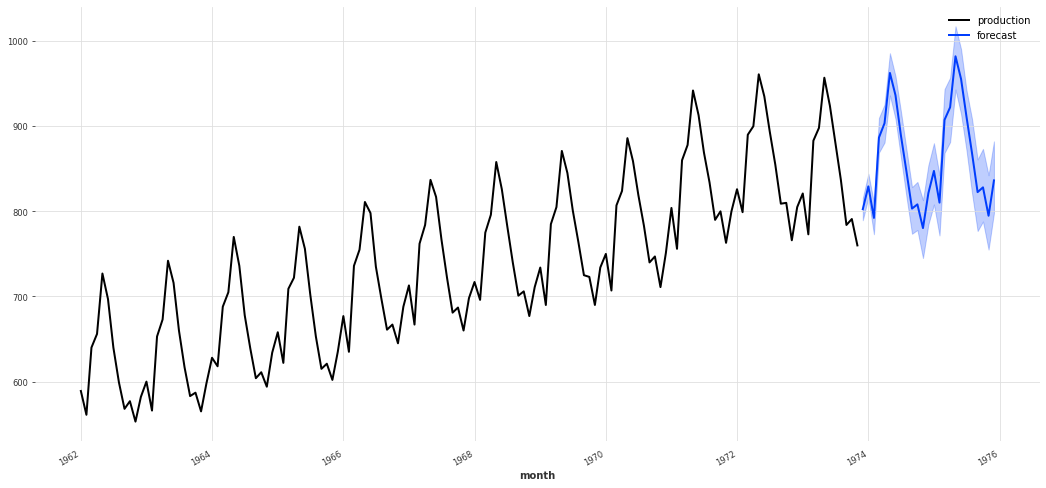

In [65]:
train, test = split_data(ts, 0.15);
model.fit(train);
forecast = model.predict(len(test), num_samples=100);
train.plot();
forecast.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)

In [66]:
model.model.summary()

Dep. Variable:,endog,No. Observations:,143
Model:,ExponentialSmoothing,SSE,7265.655
Optimized:,True,AIC,593.714
Trend:,Additive,BIC,641.119
Seasonal:,Additive,AICC,599.230
Seasonal Periods:,12,Date:,"Fri, 03 Feb 2023"
Box-Cox:,False,Time:,17:03:06
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.6859083,alpha,True
smoothing_trend,0.000000,beta,True


In [67]:
from statsmodels.tsa.arima.model import ARIMA;
from statsmodels.stats.diagnostic import acorr_ljungbox

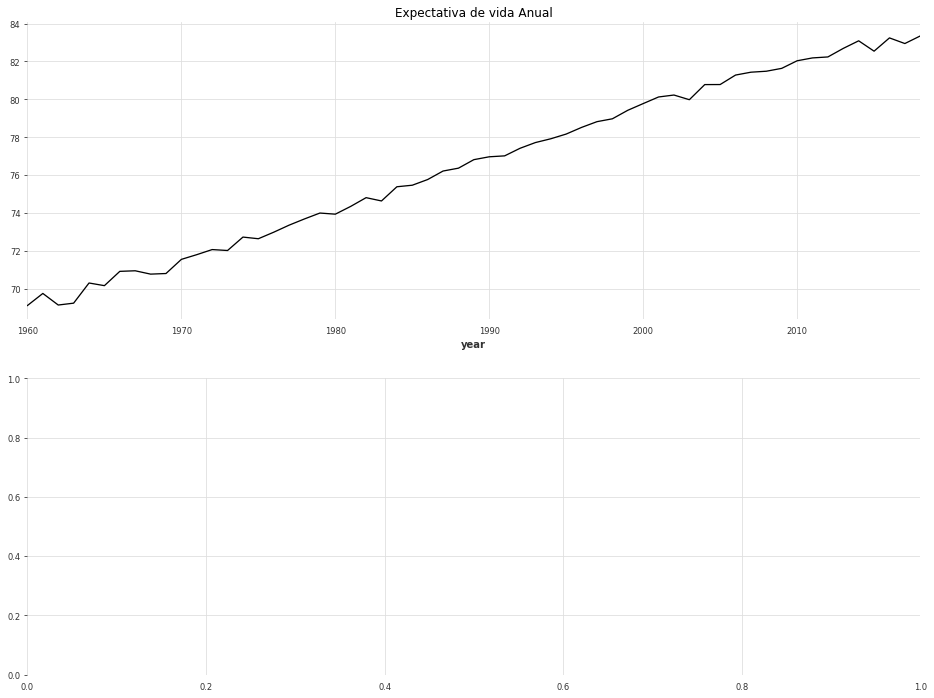

In [72]:
fig, ax = plt.subplots(2, 1, figsize = (16, 12));
life.plot(title='Expectativa de vida Anual', legend=False, ax=ax[0]);



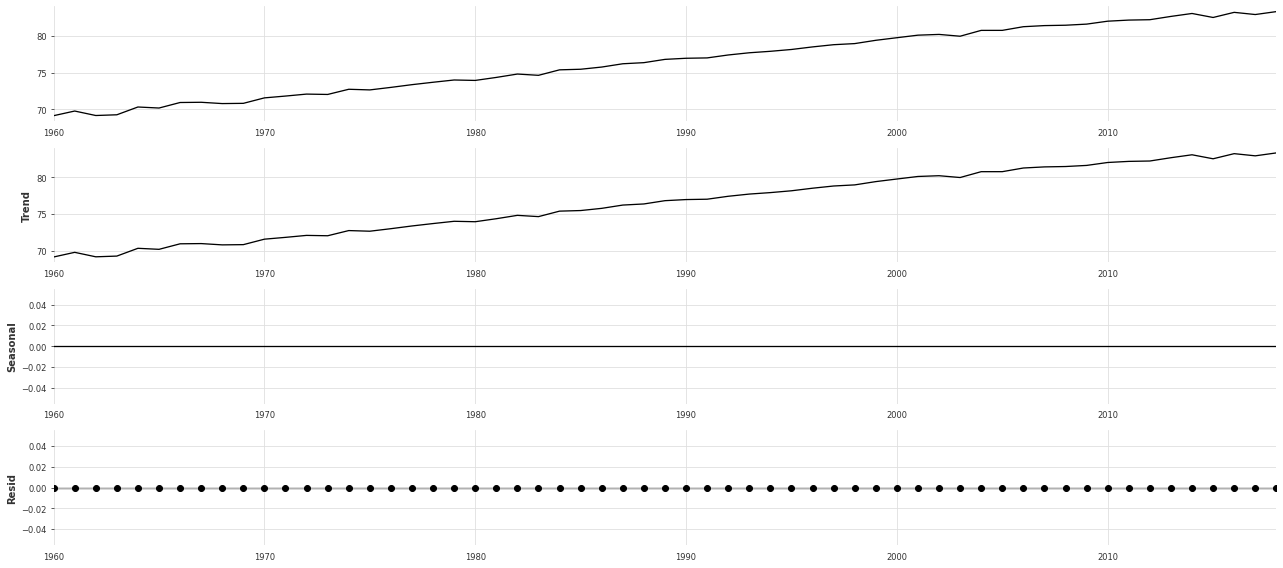

In [75]:
decomposed = seasonal_decompose(life)
decomposed.plot();
